## Part 1 ##

In [1]:
import numpy as np
from sklearn.linear_model import LassoCV as LassoCV
from sklearn.linear_model import Lasso as Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import time

In [2]:
## Note: got this func from Felix ##
def simulate_data(n, p, rng, *, sparsity=0.95, SNR=2.0, beta_scale=5.0):
    """Simulate data for Project 3, Part 1.

    Parameters
    ----------
    n : int
        Number of samples
    p : int
        Number of features
    rng : numpy.random.Generator
        Random number generator (e.g. from `numpy.random.default_rng`)
    sparsity : float in (0, 1)
        Percentage of zero elements in simulated regression coefficients
    SNR : positive float
        Signal-to-noise ratio (see explanation above)
    beta_scale : float
        Scaling for the coefficient to make sure they are large

    Returns
    -------
    X : `n x p` numpy.array
        Matrix of features
    y : `n` numpy.array
        Vector of responses
    beta : `p` numpy.array
        Vector of regression coefficients
    """
    
    X = rng.standard_normal(size=(n, p))
    q = int(np.ceil((1.0 - sparsity) * p))
    beta = np.zeros((p,), dtype=float)
    beta[:q] = beta_scale * rng.standard_normal(size=(q,))
    
    sigma = np.sqrt(np.sum(np.square(X @ beta)) / (n - 1)) / SNR

    y = X @ beta + sigma * rng.standard_normal(size=(n,))

    # Shuffle columns so that non-zero features appear
    # not simply in the first (1 - sparsity) * p columns
    idx_col = rng.permutation(p)
    
    return X[:, idx_col], y, beta[idx_col]
    

number of datasets to generate: 60
[3188.38375437 3149.0396117  3092.12460673 3013.76619943 2906.98417958
 2789.36976005 2672.58770682 2551.28619267 2428.3117888  2313.31045964
 2200.81073232 2085.37594906 1977.69603342 1872.53445291 1764.78134559
 1658.76353083 1556.73653115 1459.02321385 1367.63386178 1282.36182778
 1201.28846291 1124.50383176 1051.17819917  982.58535805  915.27506291
  853.2403975   796.26817492  740.88020216  690.04044291  641.25389231
  596.8525388   555.6882334   518.31770372  485.2848827   456.12391597
  430.3940202   407.2085404   386.54804325  368.01343949  351.44188811
  336.8193122   323.5610918   311.99108124  301.67017951  292.84407783
  285.32406692  279.11390138  273.99742286  269.73693887  266.36550494
  263.6717028   261.66029915  260.21580353  258.89211983  257.88663241
  257.61953198  257.56286841  258.04496598  258.85773418  260.1948106
  261.68553514  263.51171429  265.87452826  268.9789165   272.45382691
  276.03933291  279.67486684  283.49420708 

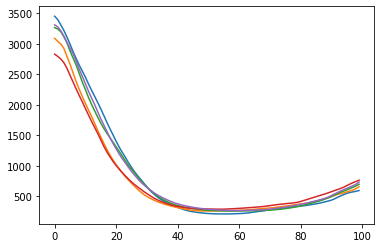

k = 0,  time ellapsed: 2.2649435997009277 seconds
[2811.89560396 2800.56919552 2774.07085173 2742.8008256  2696.84051831
 2628.49045111 2550.48922662 2449.82024667 2341.39694207 2236.20480961
 2129.21761583 2025.17415098 1923.57120604 1824.50212949 1725.10531763
 1620.39493816 1523.81540561 1435.52209433 1350.32066651 1267.4201171
 1192.17103967 1121.96838626 1053.70657267  987.53013313  925.30126161
  867.64585967  813.32840376  762.90906919  715.50774434  671.52680847
  631.05746683  592.72189576  554.92273872  520.350867    487.24120511
  456.96390014  430.3242238   407.20763967  386.08662433  366.99055064
  349.37791599  334.08912902  321.0440123   309.62939357  299.85654896
  290.85916532  282.6169632   275.35940776  268.90850335  263.40047634
  258.99255077  255.33647644  252.17530056  249.77764514  248.12950686
  247.55548587  247.92054534  248.96369506  250.62889368  252.74427561
  255.33633093  258.74442657  262.25529294  266.23713343  270.34191969
  274.88985453  279.95516977

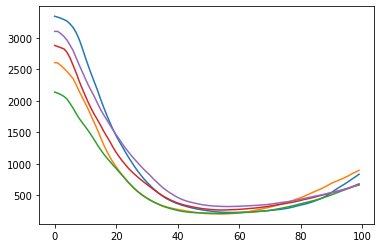

k = 1,  time ellapsed: 4.506948471069336 seconds


KeyboardInterrupt: 

In [6]:
p = 500
n_vector = [100, 300, 400]
n_test = 500
sparsity_vector = [0.75, 0.9, 0.95, 0.99]
SNR = 5.0
beta_scale = 5.0
nr_runs = 5
rng = np.random.default_rng()

nr_datasets = int(len(n_vector)*len(sparsity_vector)*nr_runs)

lambda_mins = np.zeros(nr_datasets)
lambda_1ses = np.zeros(nr_datasets)
MSE_train_min = np.zeros(nr_datasets)
MSE_test_min = np.zeros(nr_datasets)
MSE_train_1se = np.zeros(nr_datasets)
MSE_test_1se = np.zeros(nr_datasets)


k = 0
illustrate = True
verbose = True

if(verbose):
    print(f"number of datasets to generate: {nr_datasets}")
    t0 = time.time()
for n in n_vector:
    for sparsity in sparsity_vector:
        for i in range(nr_runs):
            X, y, beta = simulate_data(n + n_test, p, rng, sparsity = sparsity, SNR = SNR, beta_scale = SNR)
            X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                                test_size = round(n_test/(n_test + n)),
                                                                random_state = 0)
            
            lasso = LassoCV().fit(X_train,y_train)
            alpha_min = lasso.alpha_
            lambda_mins[k] = alpha_min
            ## Note: got this paragraph from Felix ##
            cv_mean = np.mean(lasso.mse_path_, axis=1)
            cv_std = np.std(lasso.mse_path_, axis=1)
            plt.plot(lasso.mse_path_)
            plt.show()
            idx_min_mean = np.argmin(cv_mean)
            idx_alpha = np.where(
                (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean]) &
                (cv_mean >= cv_mean[idx_min_mean])
            )[0][0]
            alpha_1se = lasso.alphas_[idx_alpha]
            
            MSE_train_min[k] = cv_mean[idx_min_mean]
            MSE_train_1se[k] = cv_mean[idx_alpha]
            lambda_1ses[k] = alpha_1se
            
            pred_min = lasso.predict(X_test)
            MSE_test_min[k] = mse(pred_min, y_test)
            
            lasso_1se = Lasso(alpha = alpha_1se).fit(X_train, y_train)
            pred_1se = lasso_1se.predict(X_test)
            MSE_test_1se[k] = mse(pred_1se,y_test)
            
            
            
            if(verbose):
                t1 = time.time()
                print(f"k = {k},  time ellapsed: {t1-t0} seconds")
            if(illustrate and k == 30):
                plt.rcParams["figure.figsize"]=13,7
                plt.imshow(X)
                plt.colorbar()
                plt.show()
                plt.rcParams["figure.figsize"]=13,5
                plt.plot(y)
                plt.show()
                plt.plot(beta)
                plt.show()
            k += 1

if(verbose):
    print(f"Total number of datasets generated: {k}")
    t2 = time.time()
    print(f"Total time ellapsed: {t2-t0} seconds")

Total number of datasets generated: 60
Total time ellapsed: 1245.6734795570374 seconds


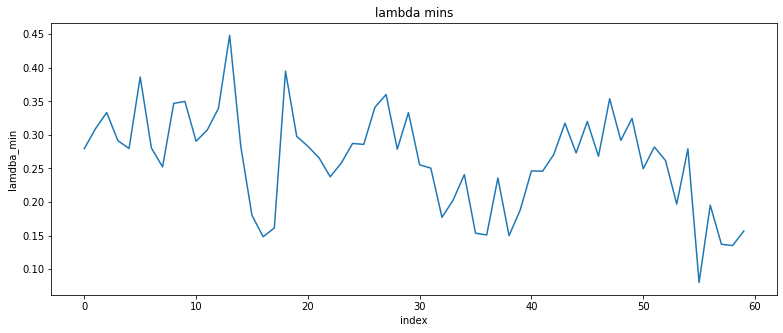

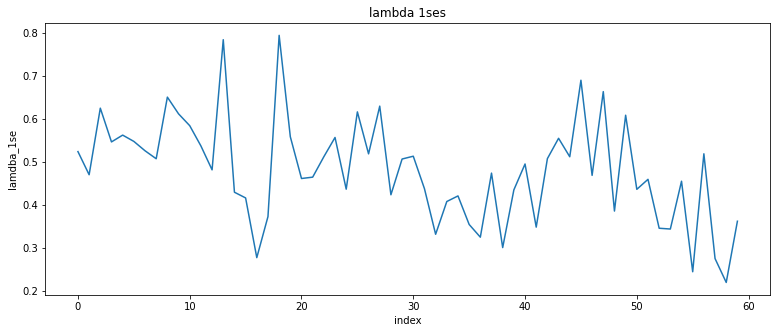

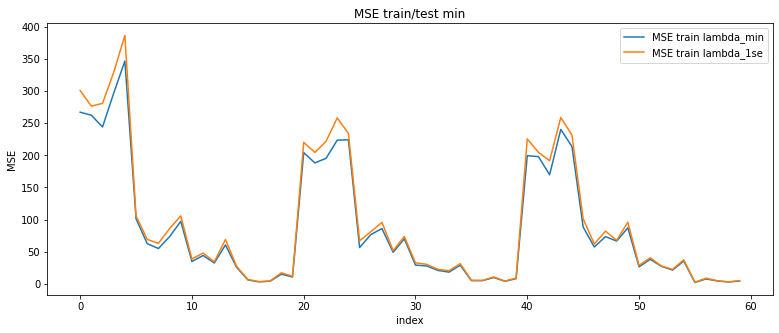

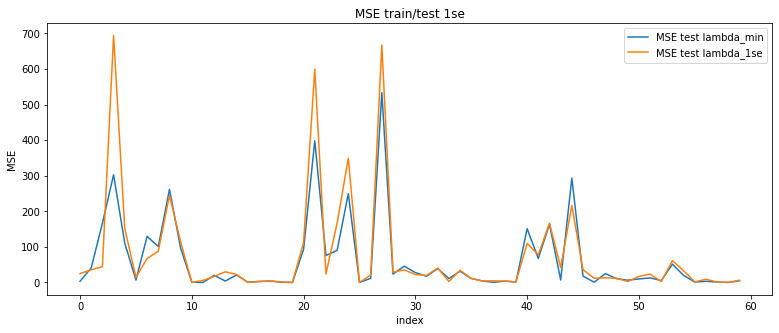

In [78]:
if(verbose):
    print(f"Total number of datasets generated: {k}")
    t2 = time.time()
    print(f"Total time ellapsed: {t2-t0} seconds")
if(illustrate):
    plt.plot(lambda_mins)
    plt.title("lambda mins")
    plt.xlabel("index")
    plt.ylabel("lamdba_min")
    plt.show()
    
    plt.plot(lambda_1ses)
    plt.title("lambda 1ses")
    plt.xlabel("index")
    plt.ylabel("lamdba_1se")
    plt.show()
    
    
    plt.plot(MSE_train_min, label = 'MSE train lambda_min')
    plt.plot(MSE_train_1se, label = 'MSE train lambda_1se')
    plt.title("MSE train/test min")
    plt.xlabel("index")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()
    
    plt.plot(MSE_test_min, label = 'MSE test lambda_min')
    plt.plot(MSE_test_1se, label = 'MSE test lambda_1se')
    plt.title("MSE train/test 1se")
    plt.xlabel("index")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()
